# Lab 3: EM and VAE

### Machine Learning 2 (2016/2017)

* The lab exercises should be made in groups of two people or individually.
* The hand-in deadline is Wednesday, May 24, 23:59.
* Assignment should be sent to p.j.j.p.versteeg@uva.nl. The subject line of your email should be "[ML2_2017] lab#_lastname1\_lastname2". 
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "[ML2_2017] lab02\_Bongers\_Blom", the attached file should be "lab02\_Bongers\_Blom.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask or e-mail Philip.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: test your code and make sure we can run your notebook / scripts before you send them!

$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included.

In [69]:
%pylab inline
import cPickle, gzip

# load data
with gzip.open('mnist_small.gz', 'r') as f:
    mnist_images, mnist_labels = cPickle.load(f)

mnist_dim = (28, 28)
print "MNIST data loaded;", \
    " number of samples:", len(mnist_labels), \
    '; number of pixels per sample:', mnist_dim[0], 'x', mnist_dim[1]

Populating the interactive namespace from numpy and matplotlib


/Users/daan/anaconda/envs/python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm', 'figure', 'sample', 'f', 'shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


MNIST data loaded;  number of samples: 5000 ; number of pixels per sample: 28 x 28


## Part 1: Expectation Maximization
We use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5)
As we like to apply our Bernoulli mixture model, convert the MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding the dataset at an appropriate level. Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

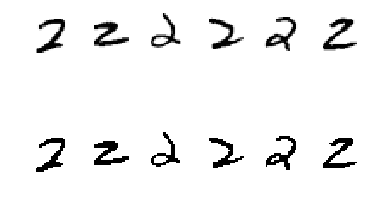

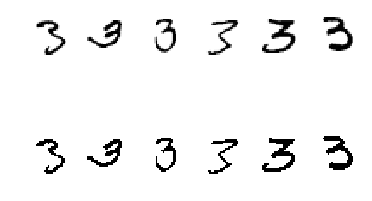

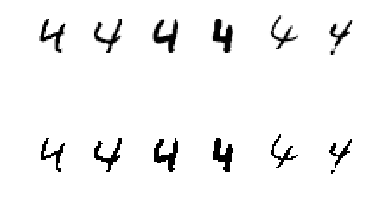

In [70]:
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    numrows = int(numdigits/numcols)
    for i in range(numdigits):
        plt.subplot(numrows, numcols, i+1) # changed i to i+1 to prevent indexing error!
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.show()
    
zipped = zip(mnist_images[0:100], mnist_labels[0:100])
# select images of digits 2, 3 and 4 
twos = np.array([im for im, num in zipped if num == 2])
threes = np.array([im for im, num in zipped if num == 3])
fours = np.array([im for im, num in zipped if num == 4])

# plot a few original images and their binarized versions stacked vertically
plot_digits(np.vstack((twos[0:6], twos[0:6] > 0.5)), numcols=6)
print('\n')
plot_digits(np.vstack((threes[0:6], threes[0:6] > 0.5)), numcols=6)
print('\n')
plot_digits(np.vstack((fours[0:6], fours[0:6] > 0.5)), numcols=6)

### 1.2 Implementation (40)
Write a function ```EM(batch, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters your function should have are:
* ```batch``` :: input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize equations in ```numpy``` as  much as possible and clearly comment in your code where the E-step and where the M-step are performed.

In [160]:
def EM(batch, K, max_iter, log=False):
    D = batch[0].shape[0]
    N = len(batch)
    
    pi = np.array([1.0/K]*K) # initialize uniformly
    draws = np.random.uniform(0.25, 0.75, size=(K, D)) # settings taken from Bishop
    mu = draws * np.sum(draws, axis=1, keepdims=True)**-1 # normalizing to meet constraint

    if log: plot_digits(mu, numcols=3)
    
    for i in range(max_iter):
        print 'Iteration {0}/{1}'.format(i+1, max_iter)
              
        # E-step
        p_tilde = np.array([[pi[k]*np.prod([mu[k][i]**batch[n][i] * (1-mu[k][i])**(1-batch[n][i]) 
                                    for i in range(D)]) 
                                        for k in range(K)] 
                                           for n in range(N)])
        norm = np.sum(p_tilde, axis=1, keepdims=True)
        # to remedy division by zero: else we get nan
        posterior = np.divide(p_tilde, norm, out=np.zeros_like(p_tilde), where=norm!=0) 
        
        # M-step
        pi = np.sum(posterior, axis=0) * np.sum(posterior)**-1
        
        mu_tilde = np.array([np.sum([batch[n] * posterior[n][k] for n in range(N)], axis=0) for k in range(K)])
        norm = np.sum(posterior, axis=0, keepdims=True).T
        mu = mu_tilde * norm**-1
        
        if log: plot_digits(mu, numcols=3)
        
    return pi, mu

### 1.2 Three digits test (10)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits. What are the identified mixing coefficients, and how do these compare to the true ones?

In [164]:
zipped = zip(mnist_images, mnist_labels)
# select images of digits 2, 3 and 4 
twos = [im for im, num in zipped if num == 2]
threes = [im for im, num in zipped if num == 3]
fours = [im for im, num in zipped if num == 4]

print(len(twos), len(threes), len(fours))

batch = np.array(twos + threes + fours) > 0.5

(512, 459, 498)


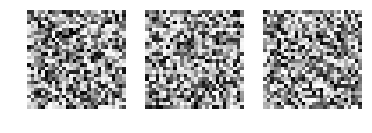

Iteration 1/10


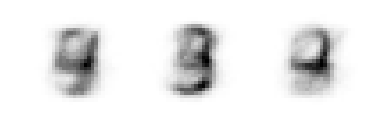

Iteration 2/10


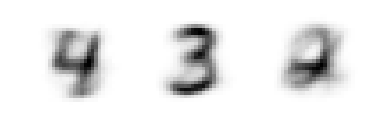

Iteration 3/10


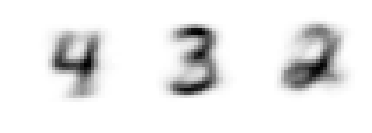

Iteration 4/10


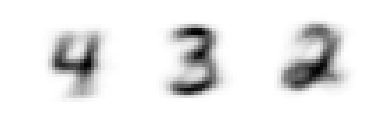

Iteration 5/10


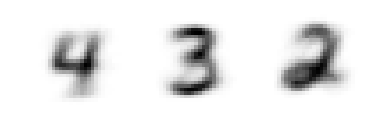

Iteration 6/10


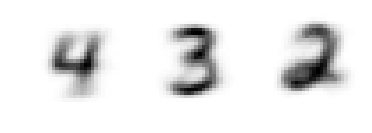

Iteration 7/10


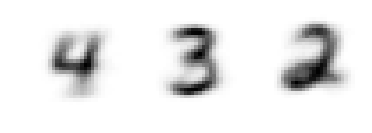

Iteration 8/10


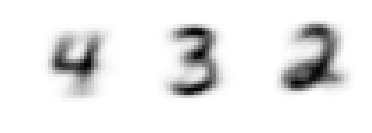

Iteration 9/10


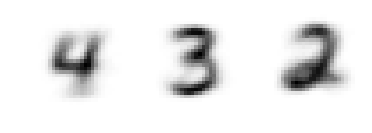

Iteration 10/10


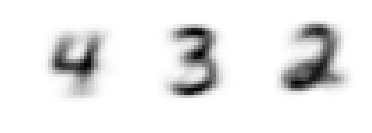

In [165]:
K = 3
pi, mu = EM(batch, K, 10, log=True)

### 1.3 More experiments (20)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation.

* __1.3.1__
    Use with more or less classes for $K$.
* __1.3.2__ 
    Use the image labels in ```mnist_labels``` to identify some misclassified images and see if you understand why.
* __1.3.3__ 
    Initialize the three classes with the true values of the parameters and see what happens.

#### 1.3.1

With more or less classes $K$.

*Five clusters*.  EM has found two clusters for the three! The clusters have differentiated between two angles at which the digit three is written: left-wards leaning and right-wards leaning. Great job EM.

In [168]:
batch = np.array(twos + threes + fours) > 0.5
K = 5
pi, mu = EM(batch, K, 10)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


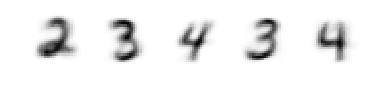

[ 0.23136158  0.22921895  0.19293467  0.15764656  0.18883824]


In [170]:
plot_digits(mu, numcols=5)
print(pi)

*Four clusters*. EM has found two clusters for the twos! The clusters have differentiated between two ways in which the digit two is written: with a loop at the left-bottom (right-most two), and without.

In [166]:
batch = np.array(twos + threes + fours) > 0.5
K = 4
pi, mu = EM(batch, K, 10)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


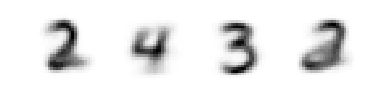

[ 0.18738632  0.39032608  0.20888672  0.21340088]


In [167]:
plot_digits(mu, numcols=4)
print(pi)

*Two clusters*. Apparently, the `2` can reduced away to somewhere in th `3` or in the `4`: the clusters for these remain clearly visible; the cluster for two has dissapeared almost completely. Almost, because we can see a small trace of a `2` in the left-bottom of the `3`, where the diagonal line of a two is somewhat visible.

In [77]:
batch = np.array(twos + threes + fours) > 0.5
K = 2
pi, mu = EM(batch, K, 10)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


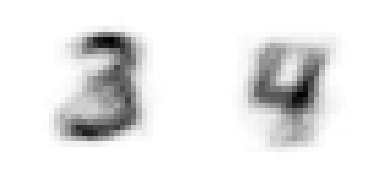

[ 0.4624547  0.5375453]


In [78]:
plot_digits(mu, numcols=2)
print(pi)

*One cluster*. Apparently, the `3` is the most representetative shape of the whole dataset: it's the mean of them all. Hence we can clump all the digits together in this one cluster-center.

In [79]:
batch = np.array(twos + threes + fours) > 0.5
K = 1
pi, mu = EM(batch, K, 10)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


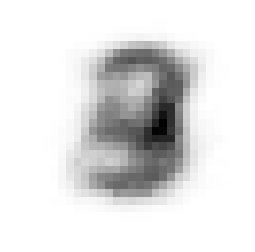

[ 1.]


In [80]:
plot_digits(mu, numcols=1)
print(pi)

#### 1.3.2

*Classifying images*. We classify an using the estimated means in `mu` image by computing the euclidean distance between each of the `mu`'s and choosing the one that it is nearest to. This method works quite well as the results of classification testify to (see below).

In [113]:
def predict(im, mu, pi):
    """
    The prediction is that mu which minimizes the 
    eclidean distance between the image and mu.
    """
    distances = list()
    for k, m in enumerate(mu):
        dist = np.linalg.norm(im - m)
        distances.append(dist)
    return np.argmin(distances)
        
def classify(batch, mu, pi, labels):
    """
    :labels: the manually determined class of each cluster in order
    """
    wrong = list()
    right = list()
    for im, num in batch:
        pred = predict(im, mu, pi)
        if not labels[pred]==num:
            wrong.append((im, labels[pred]))
        else:
            right.append((im, labels[pred]))
    return right, wrong

In [125]:
zipped = zip(mnist_images, mnist_labels)

twos = [(im,num) for im, num in zipped if num == 2]
threes = [(im,num) for im, num in zipped if num == 3]
fours = [(im,num) for im, num in zipped if num == 4]

concat = twos + threes + fours
np.random.shuffle(concat)

test = np.array(concat)

In [126]:
right, wrong = classify(test, mu, pi, labels=[4,3,2])

print('Correct total: {0}/{1} = {2}'.format(len(right), 
                                            len(wrong)+len(right), 
                                            len(right)/float(len(wrong)+len(right))))

wrong_twos = [pred for im, pred in wrong if pred==2]
print('Icorrect 2s: {0}/{1} = {2}'.format(len(wrong_twos), 
                                          len(twos), 
                                          len(wrong_twos)/float(len(twos))))

wrong_threes = [pred for im, pred in wrong if pred==3]
print('Icorrect 3s: {0}/{1} = {2}'.format(len(wrong_threes), 
                                          len(threes), 
                                          len(wrong_threes)/float(len(threes))))

wrong_fours = [pred for im, pred in wrong if pred==4]
print('Icorrect 4s: {0}/{1} = {2}'.format(len(wrong_fours), 
                                          len(fours), 
                                          len(wrong_fours)/float(len(fours))))

Correct total: 1297/1469 = 0.88291354663
Icorrect 2s: 51/512 = 0.099609375
Icorrect 3s: 41/459 = 0.0893246187364
Icorrect 4s: 80/498 = 0.160642570281


Some of the misclassified images:


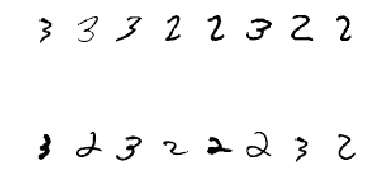

[4, 4, 2, 3, 3, 2, 3, 3, 2, 4, 2, 4, 4, 4, 4, 3]


In [171]:
ims = np.array([im for im, pred in wrong[0:16]])
preds = [pred for im, pred in wrong[0:16]]

print('Some of the misclassified images:')
plot_digits(ims, numcols=8)
print(preds)

You can see that the misclassified images are quite informatice of what is going wrong: they are quite typically written. Therefore they will be far away from the estimated means, and hence the classification will be pretty random. That said - some of the mis-classifications are rather understandable. For example the first three (from the top-left) is classified as a four, and the third three as a two. You can kind of see why.

#### 1.3.3

*Initialization at true mean*. As you can see, the EM estimate for `mu` remains fixed over the iterations. Indeed: nothing happens. And this should happen. Sinze EM is guaranteed to increase the likelihood at each itertion. And it doesn't get more likely than standing at the proper mean.

True means:


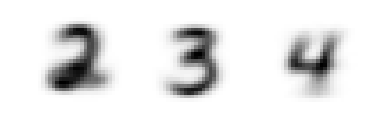

In [149]:
twos = [im for im, num in zipped if num == 2]
mu_two = np.sum(twos, axis=0, keepdims=True) / len(twos)

threes = [im for im, num in zipped if num == 3]
mu_three = np.sum(threes, axis=0, keepdims=True) / len(threes)

fours = [im for im, num in zipped if num == 4]
mu_four = np.sum(fours, axis=0, keepdims=True) / len(fours)

print('True means:')
plot_digits(np.vstack((mu_two, mu_three, mu_four)), numcols=3)

In [156]:
def EM_true_mean(batch, K, max_iter):
    D = batch[0].shape[0]
    N = len(batch)
    
    pi = np.array([1.0/K]*K) # initialize uniformly
    mu = np.vstack((mu_two, mu_three, mu_four))

    plot_digits(mu, numcols=3)
    
    for i in range(max_iter):
        print 'Iteration {0}/{1}'.format(i+1, max_iter)
              
        # E-step
        p_tilde = np.array([[pi[k]*np.prod([mu[k][i]**batch[n][i] * (1-mu[k][i])**(1-batch[n][i]) 
                                    for i in range(D)]) 
                                        for k in range(K)] 
                                           for n in range(N)])
        norm = np.sum(p_tilde, axis=1, keepdims=True)
        # to remedy division by zero: else we get nan
        posterior = np.divide(p_tilde, norm, out=np.zeros_like(p_tilde), where=norm!=0) 
        
        # M-step
        pi = np.sum(posterior, axis=0) * np.sum(posterior)**-1
        
        mu_tilde = np.array([np.sum([batch[n] * posterior[n][k] for n in range(N)], axis=0) for k in range(K)])
        norm = np.sum(posterior, axis=0, keepdims=True).T
        mu = mu_tilde * norm**-1
        
        plot_digits(mu, numcols=3)
        
    return pi, mu

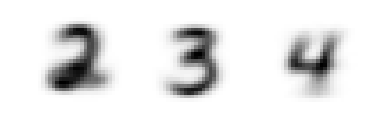

Iteration 1/10


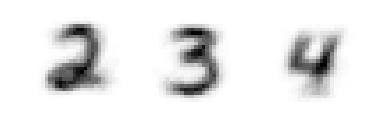

Iteration 2/10


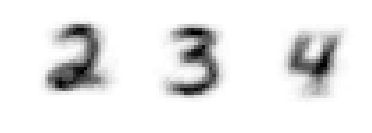

Iteration 3/10


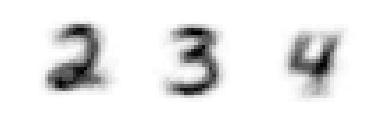

Iteration 4/10


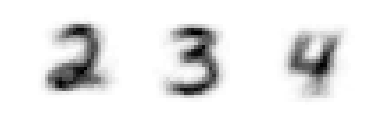

Iteration 5/10


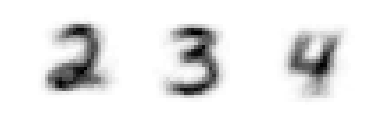

Iteration 6/10


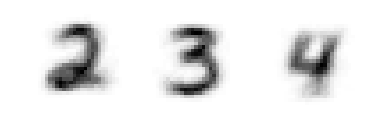

Iteration 7/10


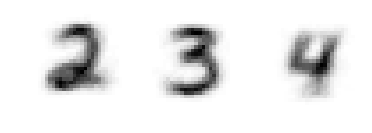

Iteration 8/10


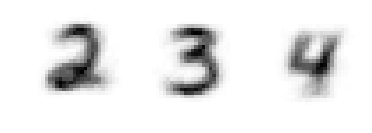

Iteration 9/10


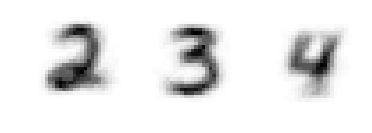

Iteration 10/10


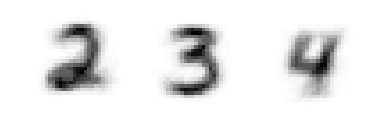

In [158]:
batch = np.array(twos + threes + fours) > 0.5
K = 3
true_mean_pi, true_mean_mu = EM_true_mean(batch, K, 10)

### 1.4 Relation to Variational Inference (5)
Propose how you would alter the Bernoulli mixture model for use with a variational method (Bishop Ch.$10$). 

Which priors would you use and why? 

**Awnser**

We could use a prior that is conjugate to the Bernouilli distribution, like the Beta distribution.

## Part 2: Variational Auto-Encoder
A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part, that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

More information can be found here:
* Original paper by Kingma (2014) https://arxiv.org/pdf/1312.6114.pdf 
* Nice but large summary (2016) https://arxiv.org/pdf/1606.05908.pdf
* One of _many_ online Tutorials, i.e. https://jaan.io/what-is-variational-autoencoder-vae-tutorial or http://kvfrans.com/variational-autoencoders-explained

### 2.1 The q-distribution (5 points)

In variational inference, we introduce distribution $q(\theta)$ over parameters / latent variables in order to make inference tractable. We can think of $q$ as being an approximation of a certain distribution. What function does $q$ approximate, $p(\bx|\theta)$, $p(\theta|\bx)$, $p(\bx, \theta)$, $p(\theta)$, or $p(\bx)$, and how do you see that from the equation $\ln p(\bx) = \mathcal{L}(q) + \mathrm{KL}(q||p)$? 


#### Answer
$q$ approximate $p(\theta)$  since it is hard to calculate the distribution $p(\theta)$. We can see from the equation that the KL divergence that measure information lost between two distribution is between $q$ and $p$. To compute the log marginal $\ln p(x)$ then we can minimize the lower bound $\mathcal{L}(q)$

### 2.2 Implementation (20 points)
Above is a version of a Variational Auto-Encoder that uses PyTorch (http://pytorch.org/). PyTorch is python package that is  particularly suited for high level programming of neural net, and is easily installable by following the instructions on their website.

Add comments to the code below, where each ```COMMENT``` line should be replaced with an explanation of the code on the line below it (this may also be one or two words) and specify the encoder and decoder parts. 

Modify the ```run(...)``` function to visualize each $200$ iterations how the model is improving. Do this by sampling a few values of the latent space $\bz$ and running those through the decoder. Add a plot of the loss function and show this after convergence. Run the 

In [38]:
import torch
import torch.nn.functional as nn
from torch.autograd import Variable

## number of samples and the dimension of the data
N_samples, X_dim = mnist_images.shape 
## batch size
mb_size = 64
## latent variable dimension
Z_dim = 100 
## hidden layer dimension
h_dim = 128 
## learning rate
lr = 1e-3

## Helper functions.
def mnist_mb(mb_size):
    """Sample batch of size mb_size from training data"""
    yield mnist_images[np.random.choice(N_samples, size=mb_size, replace=True),]
def init_weight(size):
    return Variable(torch.randn(*size) * (1. / np.sqrt(size[0] / 2.)), requires_grad=True)

## initialization of weights or parameters for the encoder network 
## xh is from the input layer to the hidden layer (W.. is the transformation, b.. the bias)
## hz is from the hidden layer to the latent variable layer (W.. is the transformation, b.. the bias)
## mu and var is the parameter for the latent variable. in this case we model Q(z|X) with Gaussian 
Wxh = init_weight(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whz_mu = init_weight(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

## function for encoder Q(z|X) which projects an input data X to the latent variable space. 
## this function takes an input data x and outputs two parameter of the latent variable:
## mean and variance.
def Q(X):
    h = nn.relu(X.mm(Wxh) + bxh.repeat(X.size(0), 1))
    z_mu = h.mm(Whz_mu) + bhz_mu.repeat(h.size(0), 1)
    z_var = h.mm(Whz_var) + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var

## function to sample from the distribution Q(z|X)
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps

## initialization of weights or parameters for the encoder network 
## xh is from the input layer to the hidden layer (W.. is the transformation, b.. the bias)
## hz is from the hidden layer to the latent variable layer (W.. is the transformation, b.. the bias)
## mu and var is the parameter for the latent variable. in this case we model Q(z|X) with Gaussian 
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

## function for decoder P(X|z) which generate data given latent variable z
def P(z):
    h = nn.relu(z.mm(Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx) + bhx.repeat(h.size(0), 1))
    return X

## parameter initialization and optimizer for stochastic optimization
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adagrad(params, lr=lr)

losses = list()
def run(num_iter):
    for iter in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        ## Feedforward X to produce mu and var for the latent variable
        z_mu, z_var = Q(X)
        ## sample z from a gaussian given mu and var 
        z = sample_z(z_mu, z_var)
        ## generate data with sampled latent variable
        X_sample = P(z)

        ## Reconstruction loss or expected negative log-likelihood. 
        ## The expectation is taken with respect to the encoder’s distribution over the representations. 
        ## This term encourages the decoder to learn to reconstruct the data
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
        ## KL divergence loss between encoder distribution q(z|X) and the real distribution p(z|X) 
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = recon_loss + kl_loss
        losses.append(loss.data.numpy()[0])

        ## Do backpropagation
        loss.backward()

        solver.step()
        for p in params:
            p.grad.data.zero_()
        
        # Print and plot every now and then
        if iter % 200 == 0:
            print('Iter-{}; Loss: {:.4}'.format(iter, loss.data[0]))

            samples = P(z).data.numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    
    # plot losses over iterations
    plt.clf()
    plt.plot(range(len(losses)), losses)

Iter-0; Loss: 236.2
Iter-200; Loss: 236.2
Iter-400; Loss: 223.3
Iter-600; Loss: 214.9
Iter-800; Loss: 210.1
Iter-1000; Loss: 218.4
Iter-1200; Loss: 212.8
Iter-1400; Loss: 201.9
Iter-1600; Loss: 214.3
Iter-1800; Loss: 212.7
Iter-2000; Loss: 204.0
Iter-2200; Loss: 211.1
Iter-2400; Loss: 203.9
Iter-2600; Loss: 209.0
Iter-2800; Loss: 200.2
Iter-3000; Loss: 204.3
Iter-3200; Loss: 198.7
Iter-3400; Loss: 199.5
Iter-3600; Loss: 203.2
Iter-3800; Loss: 191.1
Iter-4000; Loss: 204.8


/Users/daan/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iter-4200; Loss: 203.6
Iter-4400; Loss: 202.8
Iter-4600; Loss: 194.6
Iter-4800; Loss: 189.6
Iter-5000; Loss: 196.0
Iter-5200; Loss: 196.9
Iter-5400; Loss: 198.1
Iter-5600; Loss: 208.2
Iter-5800; Loss: 189.1
Iter-6000; Loss: 197.2
Iter-6200; Loss: 191.6
Iter-6400; Loss: 194.2
Iter-6600; Loss: 192.1
Iter-6800; Loss: 186.6
Iter-7000; Loss: 177.1
Iter-7200; Loss: 172.1
Iter-7400; Loss: 190.2
Iter-7600; Loss: 189.8
Iter-7800; Loss: 189.4
Iter-8000; Loss: 180.2
Iter-8200; Loss: 177.1
Iter-8400; Loss: 187.2
Iter-8600; Loss: 188.8
Iter-8800; Loss: 182.4
Iter-9000; Loss: 189.2
Iter-9200; Loss: 172.3
Iter-9400; Loss: 174.3
Iter-9600; Loss: 182.5
Iter-9800; Loss: 181.6


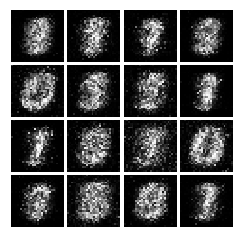

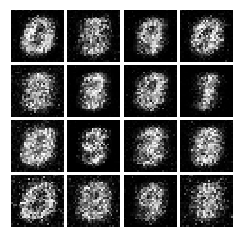

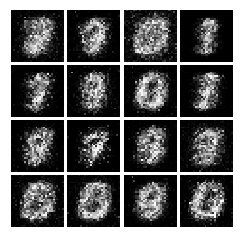

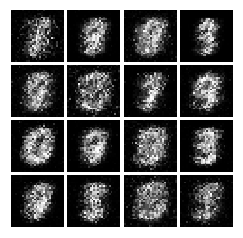

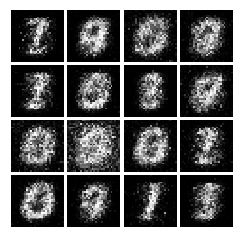

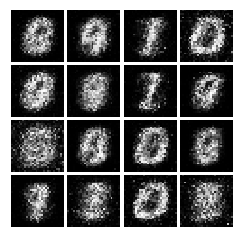

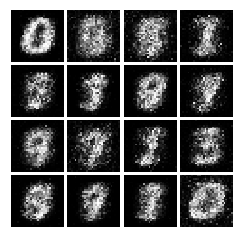

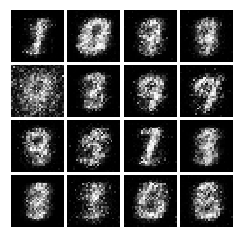

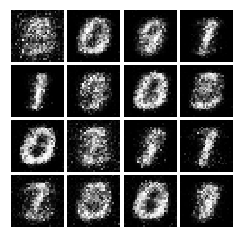

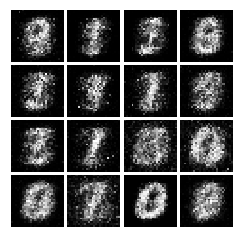

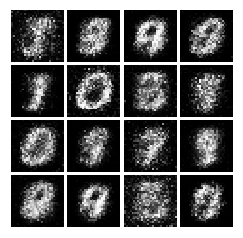

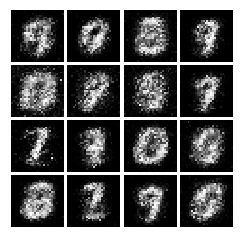

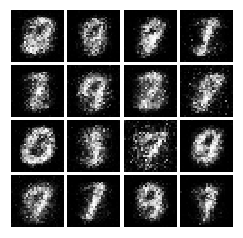

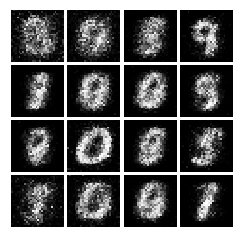

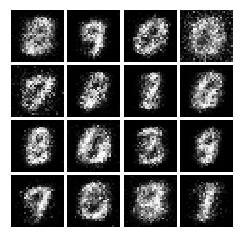

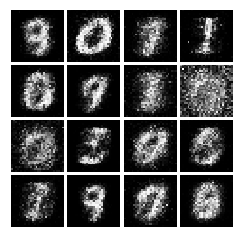

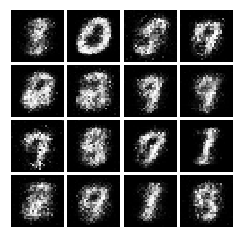

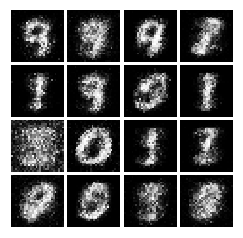

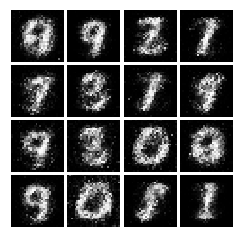

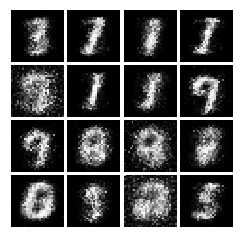

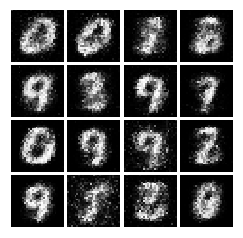

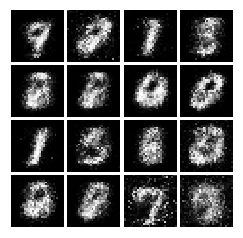

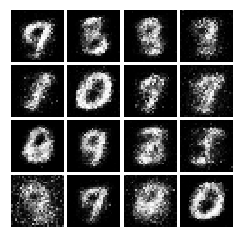

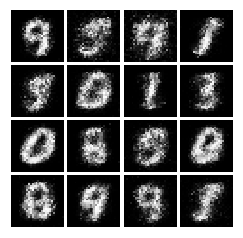

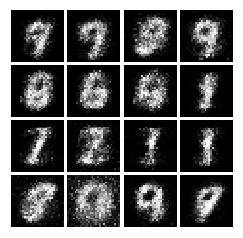

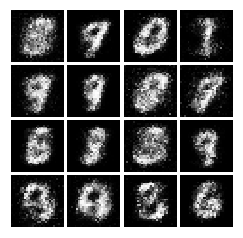

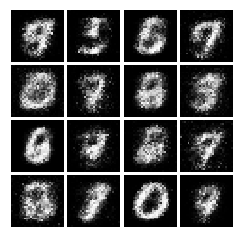

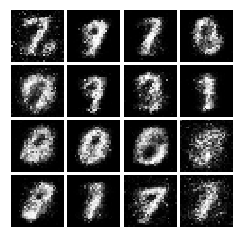

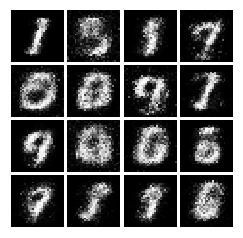

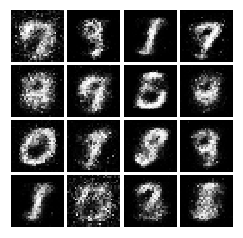

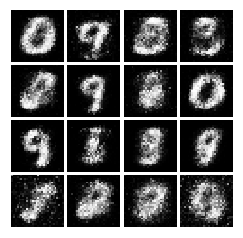

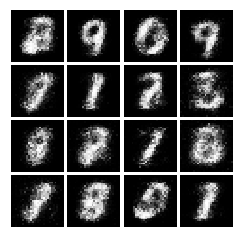

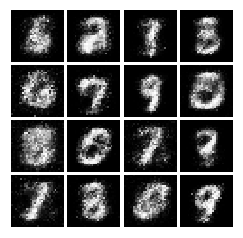

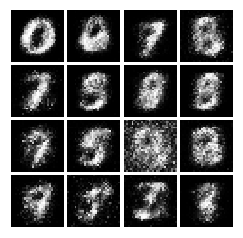

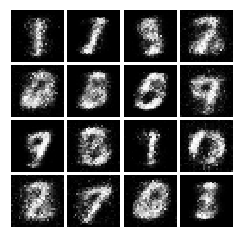

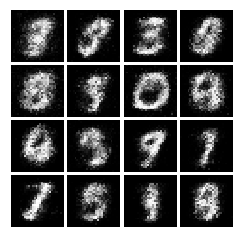

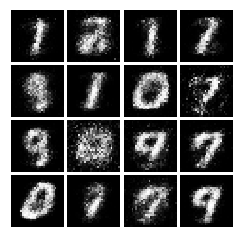

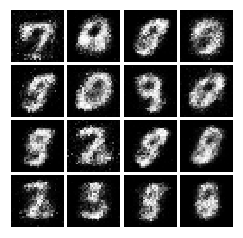

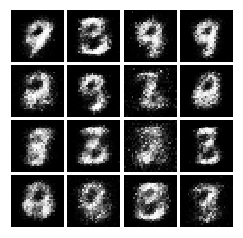

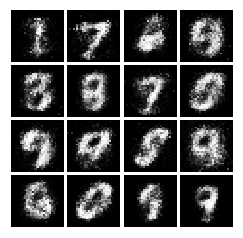

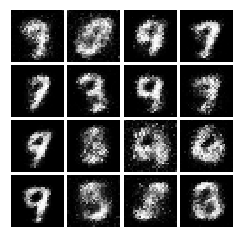

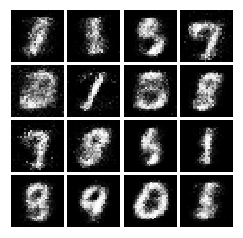

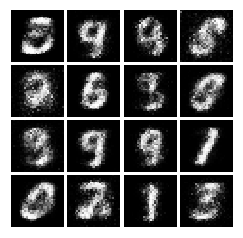

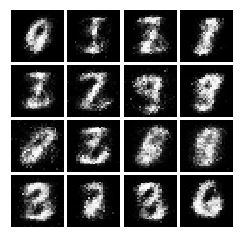

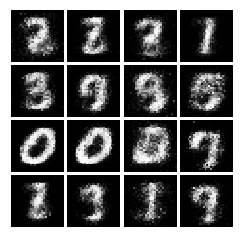

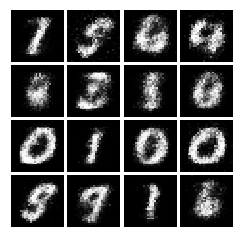

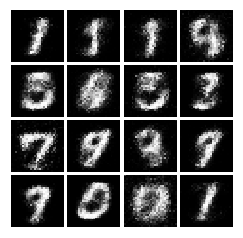

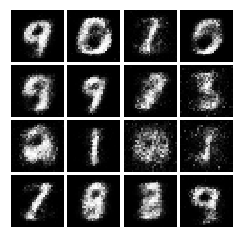

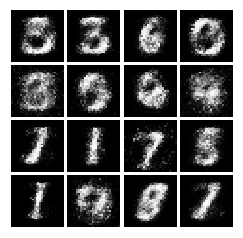

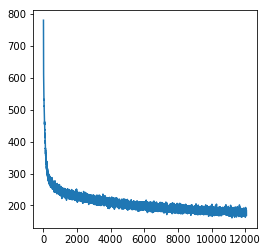

In [41]:
run(10000)

### 2.3 Visualize latent space (15)
Implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space. 

Compare your result to Kingma 2014, Appendix A. What are the differences and why?

In [67]:
import torch
import torch.nn.functional as nn
from torch.autograd import Variable
import matplotlib.gridspec as gridspec

## number of samples and the dimension of the data (784)
N_samples, X_dim = mnist_images.shape 
## batch size
mb_size = 64
## latent variable dimension
Z_dim = 2 
## hidden layer dimension
h_dim = 1000
## learning rate
lr = 1e-3

## Helper functions.
def mnist_mb(mb_size):
    """Sample batch of size mb_size from training data"""
    yield mnist_images[np.random.choice(N_samples, size=mb_size, replace=True),]
def init_weight(size):
    return Variable(torch.randn(*size) * (1. / np.sqrt(size[0] / 2.)), requires_grad=True)

## initialization of weights or parameters for the encoder network 
## xh is from the input layer to the hidden layer (W.. is the transformation, b.. the bias)
## hz is from the hidden layer to the latent variable layer (W.. is the transformation, b.. the bias)
## mu and var is the parameter for the latent variable. in this case we model Q(z|X) with Gaussian 
Wxh = init_weight(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)
Whz_mu = init_weight(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)
Whz_var = init_weight(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

## function for encoder Q(z|X) which projects an input data X to the latent variable space. 
## this function takes an input data x and outputs two parameter of the latent variable:
## mean and variance.
def Q(X):
    h = nn.relu(X.mm(Wxh) + bxh.repeat(X.size(0), 1))
    z_mu = h.mm(Whz_mu) + bhz_mu.repeat(h.size(0), 1)
    z_var = h.mm(Whz_var) + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var

## function to sample from the distribution Q(z|X)
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps

## initialization of weights or parameters for the decoder network 
## zh is from the latent variable layer to the hidden layer
## hx is from the hidden layer to the input layer
Wzh = init_weight(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
Whx = init_weight(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

## function for decoder P(X|z) which generate data given latent variable z
def P(z):
    h = nn.relu(z.mm(Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h.mm(Whx) + bhx.repeat(h.size(0), 1))
    return X

## parameter initialization and optimizer for stochastic optimization
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var, Wzh, bzh, Whx, bhx]
solver = torch.optim.Adagrad(params, lr=lr)

losses = list()
def run(num_iter, k=200):
    for iter in range(num_iter):
        ## Load data.
        X = mnist_mb(mb_size=mb_size).next()
        X = Variable(torch.from_numpy(X))

        ## Feedforward X to produce mu and var for the latent variable
        z_mu, z_var = Q(X)
        ## sample z from a gaussian given mu and var 
        z = sample_z(z_mu, z_var)
        ## generate data with sampled latent variable
        X_sample = P(z)

        ## Reconstruction loss or expected negative log-likelihood. 
        ## The expectation is taken with respect to the encoder’s distribution over the representations. 
        ## This term encourages the decoder to learn to reconstruct the data
        recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
        ## KL divergence loss between encoder distribution q(z|X) and the real distribution p(z|X) 
        kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
        loss = recon_loss + kl_loss
        losses.append(loss.data.numpy()[0])

        ## Do backpropagation
        loss.backward()

        solver.step()
        for p in params:
            p.grad.data.zero_()
        
        # Print and plot every now and then
        if iter % k == 0:
            print('Iter-{}; Loss: {:.4}'.format(iter, loss.data[0]))

            samples = P(z).data.numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    # plot losses over iterations
    plt.clf()
    plt.plot(range(len(losses)), losses)

In [ ]:
def embedding_scatter(n):
    '''
    plots the trained (mu, log sigma^2)-embeddings in Z-space
    of the first n mnist digits
    '''
    labels = np.array(mnist_labels[0:n])*1/10. # scale for coloring
    plt.figure()
    M = mnist_images[0:n]
    X = Variable(torch.from_numpy(M))
    z_mu, z_var = Q(X)
    
    cmap = plt.cm.jet
    plt.scatter(z_mu.data.numpy(), z_var.data.numpy(), s=15, c=cmap(labels))
    plt.show()

# One run

Iter-0; Loss: 654.5
Iter-200; Loss: 189.9
Iter-400; Loss: 190.7
Iter-600; Loss: 177.9
Iter-800; Loss: 172.1


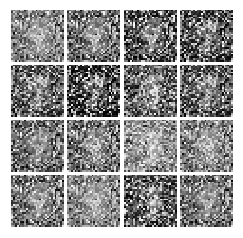

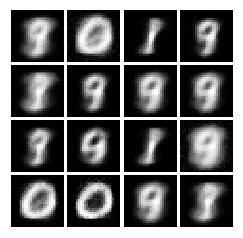

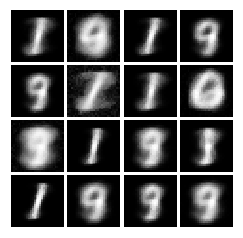

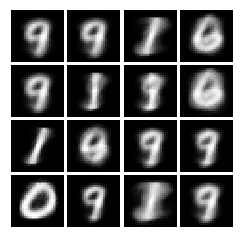

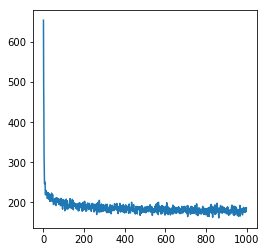

In [58]:
run(1000)

Unfortunately, the following visualization does not work as hoped: no clustering of the digits (similar colors) is visible. (Or perhaps the network is not as well trained as in the [tutorial](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)?)

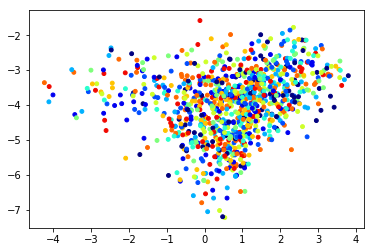

In [59]:
embedding_scatter(500)

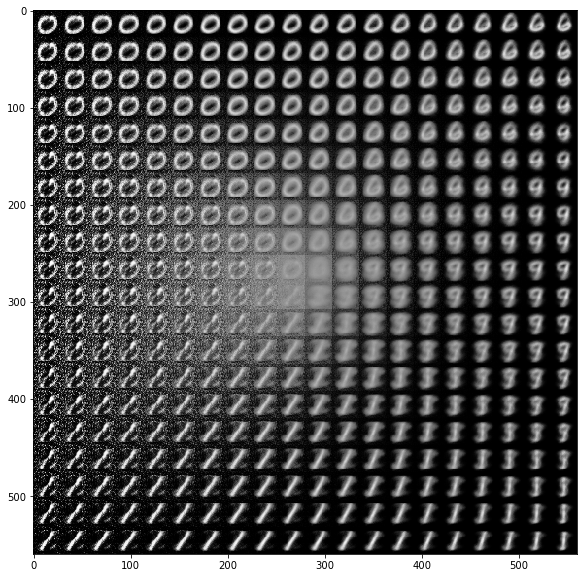

In [61]:
# reference : https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py

from scipy.stats import norm
# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Kignma (2014) Appendix A:
# "linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian"
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z = np.array([xi,yi], dtype=np.float32)
        z = Variable(torch.from_numpy(z))
        z = z.repeat(mb_size, 1).view(mb_size,-1)
        x_decoded = P(z)
        
        digit = x_decoded[0].view(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.data.numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Another run

Iter-0; Loss: 802.1
Iter-1000; Loss: 183.3
Iter-2000; Loss: 178.2
Iter-3000; Loss: 174.6
Iter-4000; Loss: 182.8
Iter-5000; Loss: 172.2
Iter-6000; Loss: 177.4
Iter-7000; Loss: 176.7
Iter-8000; Loss: 167.7
Iter-9000; Loss: 157.5


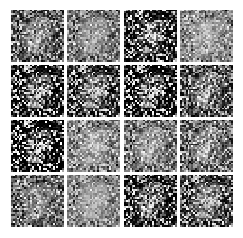

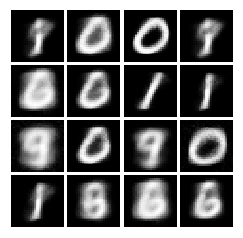

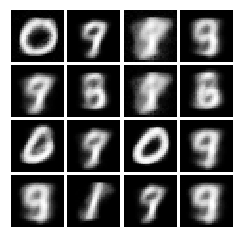

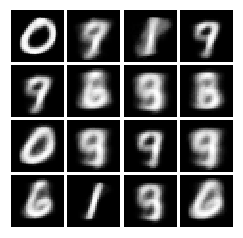

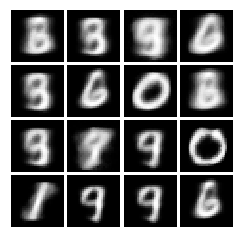

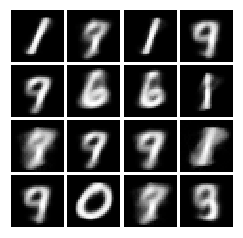

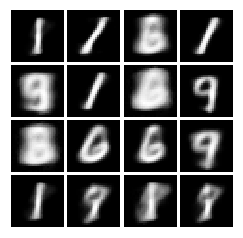

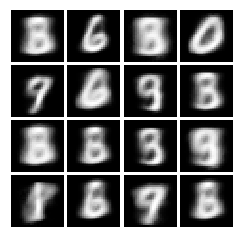

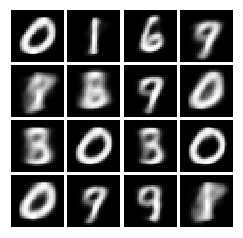

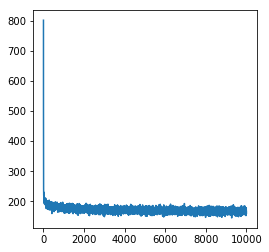

In [64]:
run(10000, k=1000)

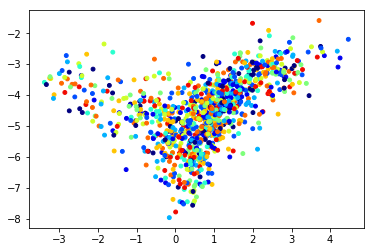

In [66]:
embedding_scatter(500)

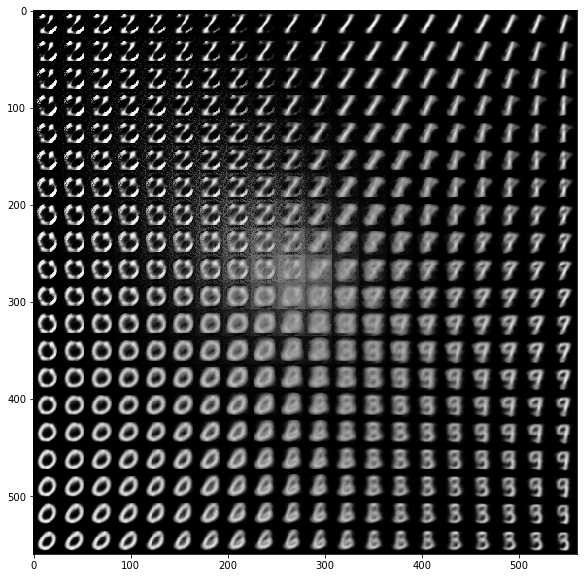

In [65]:
# reference : https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py

from scipy.stats import norm
# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Kignma (2014) Appendix A:
# "linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian"
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z = np.array([xi,yi], dtype=np.float32)
        z = Variable(torch.from_numpy(z))
        z = z.repeat(mb_size, 1).view(mb_size,-1)
        x_decoded = P(z)
        
        digit = x_decoded[0].view(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.data.numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

space

# Yet another run

Iter-0; Loss: 660.6
Iter-5000; Loss: 163.0


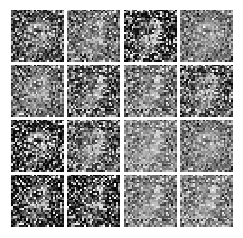

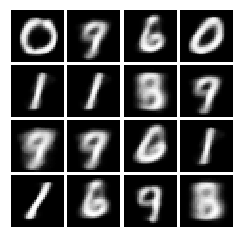

In [131]:
run(10000)

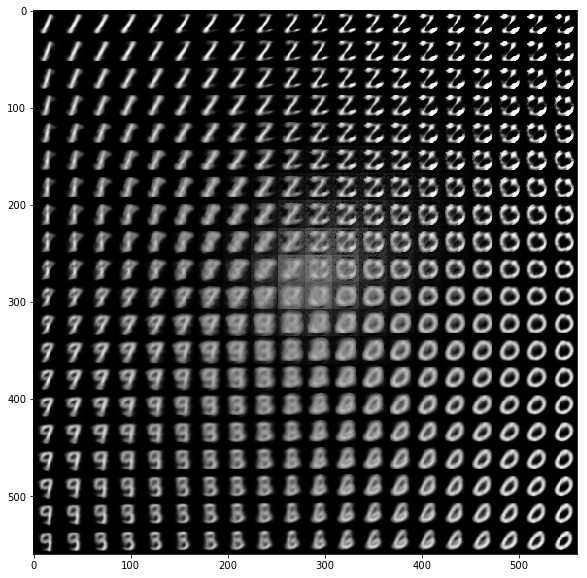

In [132]:
# reference : https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py

from scipy.stats import norm
# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Kignma (2014) Appendix A:
# "linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian"
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z = np.array([xi,yi], dtype=np.float32)
        z = Variable(torch.from_numpy(z))
        z = z.repeat(mb_size, 1).view(mb_size,-1)
        x_decoded = P(z)
        
        digit = x_decoded[0].view(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.data.numpy()t

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

We've tried our best to get plots as nice as mr. Kingma, but we are mere mortal machine-learning students. Also: we do not have that much data; 5000 images is a small subset of the MNIST data-set. But it could also be due to the choice of the network-size, or the size of the hidden layer, although it is mentioned that they used a hidden layer of 500 units, and that 'relative performance [...] was not very sensitive to these choices'.

So far for reasons why - here's whats different. Our plot clearly contains these three digits: `0`, `1`, and `9`. Not so clearly, but still visible are: `6`, `2`. With (much) more creativity we can maybe see a `3`, a `7` and an `8`. Still. Not as awesome as we hoped for.

Interestingly, these results are consistent with each of the plots we've made of each run. Perhaps the most distinctive digits are the digits `0`, `1`, and `9`: as if they are the 'limiting shapes' in our plots.